[View in Colaboratory](https://colab.research.google.com/github/sharathsrini/Expirements/blob/master/RRT-star.ipynb)

Start rrt planning
4.17953109741
[[0, 10], [-0.09158486505743407, 9.584869515697504], [-0.8277349280489218, 6.299125456465949], [-1.618264881818475, 3.795270937976784], [-1.9001962112905446, 2.186182314376258], [0, 0]]


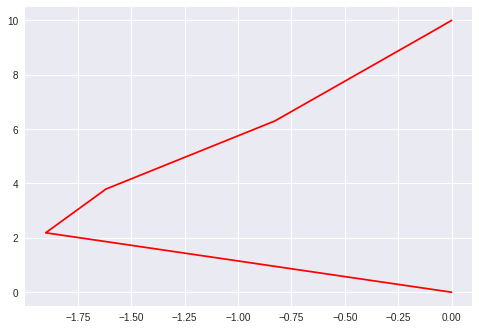

In [29]:

import random
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import time

show_animation = True


class RRT():
   
    def __init__(self, start, goal, obstacleList, randArea,
                 expandDis=0.5, goalSampleRate=20, maxIter=1000):
        
        self.start = Node(start[0], start[1])
        self.end = Node(goal[0], goal[1])
        self.minrand = randArea[0]
        self.maxrand = randArea[1]
        self.expandDis = expandDis
        self.goalSampleRate = goalSampleRate
        self.maxIter = maxIter
        self.obstacleList = obstacleList

    def Planning(self):
       

        self.nodeList = [self.start]
        for i in range(self.maxIter):
            rnd = self.get_random_point()
            nind = self.GetNearestListIndex(self.nodeList, rnd)

            newNode = self.steer(rnd, nind)
            #  print(newNode.cost)

            if self.__CollisionCheck(newNode, self.obstacleList):
                nearinds = self.find_near_nodes(newNode)
                newNode = self.choose_parent(newNode, nearinds)
                self.nodeList.append(newNode)
                self.rewire(newNode, nearinds)

            

        # generate coruse
        lastIndex = self.get_best_last_index()
        if lastIndex is None:
            return None
        path = self.gen_final_course(lastIndex)
        return path

    def choose_parent(self, newNode, nearinds):
        if len(nearinds) == 0:
            return newNode

        dlist = []
        for i in nearinds:
            dx = newNode.x - self.nodeList[i].x
            dy = newNode.y - self.nodeList[i].y
            d = math.sqrt(dx ** 2 + dy ** 2)
            theta = math.atan2(dy, dx)
            if self.check_collision_extend(self.nodeList[i], theta, d):
                dlist.append(self.nodeList[i].cost + d)
            else:
                dlist.append(float("inf"))

        mincost = min(dlist)
        minind = nearinds[dlist.index(mincost)]

        if mincost == float("inf"):
            print("mincost is inf")
            return newNode

        newNode.cost = mincost
        newNode.parent = minind

        return newNode

    def steer(self, rnd, nind):

        # expand tree
        nearestNode = self.nodeList[nind]
        theta = math.atan2(rnd[1] - nearestNode.y, rnd[0] - nearestNode.x)
        newNode = copy.deepcopy(nearestNode)
        newNode.x += self.expandDis * math.cos(theta)
        newNode.y += self.expandDis * math.sin(theta)

        newNode.cost += self.expandDis
        newNode.parent = nind
        return newNode

    def get_random_point(self):
      #A function that can approximate random points on the grid.   

        if random.randint(0, 100) > self.goalSampleRate:
            rnd = [random.uniform(self.minrand, self.maxrand),
                   random.uniform(self.minrand, self.maxrand)]
        else:  # goal point sampling
            rnd = [self.end.x, self.end.y]

        return rnd

    def get_best_last_index(self):

        disglist = [self.calc_dist_to_goal(
            node.x, node.y) for node in self.nodeList]
        goalinds = [disglist.index(i) for i in disglist if i <= self.expandDis]
        #  print(goalinds)

        if len(goalinds) == 0:
            return None

        mincost = min([self.nodeList[i].cost for i in goalinds])
        for i in goalinds:
            if self.nodeList[i].cost == mincost:
                return i

        return None

    def gen_final_course(self, goalind):
        path = [[self.end.x, self.end.y]]
        while self.nodeList[goalind].parent is not None:
            node = self.nodeList[goalind]
            path.append([node.x, node.y])
            goalind = node.parent
        path.append([self.start.x, self.start.y])
        return path

    def calc_dist_to_goal(self, x, y):
        return np.linalg.norm([x - self.end.x, y - self.end.y])

    def find_near_nodes(self, newNode):
        nnode = len(self.nodeList)
        r = 50.0 * math.sqrt((math.log(nnode) / nnode))
        #r = self.expandDis * 5.0
        dlist = [(node.x - newNode.x) ** 2 +
                 (node.y - newNode.y) ** 2 for node in self.nodeList]
        nearinds = [dlist.index(i) for i in dlist if i <= r ** 2]
        return nearinds

    def rewire(self, newNode, nearinds):
        nnode = len(self.nodeList)
        for i in nearinds:
            nearNode = self.nodeList[i]

            dx = newNode.x - nearNode.x
            dy = newNode.y - nearNode.y
            d = math.sqrt(dx ** 2 + dy ** 2)

            scost = newNode.cost + d

            if nearNode.cost > scost:
                theta = math.atan2(dy, dx)
                if self.check_collision_extend(nearNode, theta, d):
                    nearNode.parent = nnode - 1
                    nearNode.cost = scost

    def check_collision_extend(self, nearNode, theta, d):

        tmpNode = copy.deepcopy(nearNode)

        for i in range(int(d / self.expandDis)):
            tmpNode.x += self.expandDis * math.cos(theta)
            tmpNode.y += self.expandDis * math.sin(theta)
            if not self.__CollisionCheck(tmpNode, self.obstacleList):
                return False

        return True


    def GetNearestListIndex(self, nodeList, rnd):
      
      
      #Find th next closest node to expand. 
      #This function will help us get the node that finds a node which is 
      #close to both the node that we are in and the point chiosen in random
      
        dlist = [(node.x - rnd[0]) ** 2 + (node.y - rnd[1])
                 ** 2 for node in nodeList]
        minind = dlist.index(min(dlist))

        return minind

    def __CollisionCheck(self, node, obstacleList):
      
      # Check for collision , if the distance is less than 3m, 
      # there is no occurence of any collison in tghe chosen node
        for (ox, oy, size) in obstacleList:
            dx = ox - node.x
            dy = oy - node.y
            d = dx * dx + dy * dy
            if d <= 3:
                return False  # collision

        return True  # safe


class Node():
    """
    RRT Node
    """

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.cost = 0.0
        self.parent = None


def main():
    print("Start rrt planning")
    starttime = time.time()

    # ====Search Path with RRT====
    obstacleList = [
        (0,3,1)
        
        
    ]  # [x,y,size(radius)]

    # Set Initial parameters
    rrt = RRT(start=[0, 0], goal=[0, 10],
              randArea=[-2, 10], obstacleList=obstacleList)
    path = rrt.Planning()
    endtime = time.time()
    print(endtime-starttime)
    print(path)

    # Draw final path
    if show_animation:
        plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
        plt.grid(True)
        #plt.pause(0.01)  # Need for Mac
        plt.show()


if __name__ == '__main__':
    main()

In [0]:
l = [2,3,4]
for i in()